# LAB 01:  Basic Feature Engineering in Keras 

**Learning Objectives**

* Setup up the environment
* Create the project datasets
* Create an input pipeline using tf.data
* Apply feature engineering techniques to transform the input data
* Build, train, and evaluate a Keras Sequential DNN Model 
* Load and preprocess test data
* Create and test a prediction model
* Evaluate model performance
* Apply feature engineering to improve model performance


## Introduction 
In this lab, we utilize feature engineering to improve the prediction of California housing prices.  We will use TensorFlow and Keras to build a housing prices DNN prediction model, using feature engineering to improve and create a final model.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solution/feateng-solution_bqml.ipynb). **NOTE TO SELF**:  UPDATE HYPERLINK. 

### Set up environment variables and load necessary libraries

In [8]:
%%bash
export PROJECT=$(gcloud config list project --format "value(core.project)")
echo "Your current GCP Project Name is: "$PROJECT

Your current GCP Project Name is: 


In [0]:
import os

PROJECT = "cloud-training-demos" # REPLACE WITH YOUR PROJECT NAME
REGION = "us-west1-b" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["REGION"] = REGION
os.environ["BUCKET"] = PROJECT # DEFAULT BUCKET WILL BE PROJECT ID

if PROJECT == "your-gcp-project-here":
  print("Don't forget to update your PROJECT name! Currently:", PROJECT)

## Import TensorFlow and other libraries

In [10]:
!pip install sklearn

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from keras.utils import plot_model
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

# PART 1:  Set-Up



#### **Exercise**:   **REVIEW and THEN RUN** all cells in Part 1. This helps us get the data, validate data pre-processing and ensure that the data is ready for the neural network.

## The Source Dataset

The California housing dataset data contains 20,640 observations on 10 variables.  The data has been pre-processed so that there are no missing values.



#### **Exercise**:   **RUN** the query to create a Pandas dataframe

In [15]:
#NOTE TO Lab Reviewers: Lab requires students to clone the training-data-analyst repo in the Qwiklab portion,

dataframe = pd.read_csv('housing_pre-proc.csv', error_bad_lines=False)
dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [16]:
#See datatype for each feature

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20433 entries, 0 to 20432
Data columns (total 10 columns):
longitude             20433 non-null float64
latitude              20433 non-null float64
housing_median_age    20433 non-null float64
total_rooms           20433 non-null float64
total_bedrooms        20433 non-null float64
population            20433 non-null float64
households            20433 non-null float64
median_income         20433 non-null float64
median_house_value    20433 non-null float64
ocean_proximity       20433 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [17]:
#Check for null values

dataframe.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

####  Split the dataset for ML

The dataset we loaded was a single CSV file. We will split this into train, validation, and test sets.


In [18]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

13076 train examples
3270 validation examples
4087 test examples


In [19]:
#Print out the output.  

print("\nTrain:\n")
print(train.head())
print(train.shape)

print("\nValidati:\n")
print(val.head())
print(val.shape)

print("\nTest:\n")
print(test.head())
print(test.shape)


Train:

       longitude  latitude  ...  median_house_value  ocean_proximity
14781    -116.98     32.62  ...            184300.0       NEAR OCEAN
9534     -121.00     37.25  ...             97600.0           INLAND
2077     -119.79     36.76  ...             61300.0           INLAND
11013    -117.91     33.85  ...            156700.0        <1H OCEAN
15064    -117.09     32.98  ...            268800.0        <1H OCEAN

[5 rows x 10 columns]
(13076, 10)

Validati:

       longitude  latitude  ...  median_house_value  ocean_proximity
7579     -118.22     33.83  ...            175200.0        <1H OCEAN
15664    -122.42     37.76  ...            225000.0         NEAR BAY
19554    -122.24     40.19  ...             70500.0           INLAND
4057     -118.40     34.15  ...            380400.0        <1H OCEAN
392      -122.33     37.89  ...            207400.0         NEAR BAY

[5 rows x 10 columns]
(3270, 10)

Test:

       longitude  latitude  ...  median_house_value  ocean_proximity
3536 

Now, we need to output the split files.  We will specifically need the test.csv later for testing.  You should see the files appear in the home directory.


In [20]:
train.to_csv('train.csv', encoding='utf-8', index=False)
train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14781,-116.98,32.62,6.0,7995.0,1458.0,4771.0,1376.0,4.7068,184300.0,NEAR OCEAN
9534,-121.00,37.25,31.0,1923.0,341.0,806.0,349.0,3.1738,97600.0,INLAND
2077,-119.79,36.76,52.0,2408.0,498.0,1361.0,465.0,2.1055,61300.0,INLAND
11013,-117.91,33.85,35.0,932.0,258.0,1147.0,267.0,2.7014,156700.0,<1H OCEAN
15064,-117.09,32.98,23.0,1125.0,273.0,687.0,308.0,2.3182,268800.0,<1H OCEAN


In [21]:
val.to_csv('val.csv', encoding='utf-8', index=False)
val.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
7579,-118.22,33.83,43.0,1426.0,272.0,871.0,276.0,3.7083,175200.0,<1H OCEAN
15664,-122.42,37.76,52.0,1190.0,400.0,1270.0,332.0,2.0329,225000.0,NEAR BAY
19554,-122.24,40.19,29.0,1912.0,336.0,859.0,325.0,3.7000,70500.0,INLAND
4057,-118.40,34.15,41.0,2394.0,500.0,837.0,417.0,4.3889,380400.0,<1H OCEAN
392,-122.33,37.89,42.0,1342.0,291.0,551.0,266.0,4.5268,207400.0,NEAR BAY


In [22]:
test.to_csv('test.csv', encoding='utf-8', index=False)
test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
3536,-118.58,34.23,29.0,3907.0,773.0,2037.0,727.0,4.1023,230200.0,<1H OCEAN
12373,-121.48,38.57,38.0,2809.0,805.0,1243.0,785.0,1.8512,114100.0,INLAND
1353,-122.02,38.02,44.0,1465.0,247.0,817.0,237.0,4.8693,156900.0,NEAR BAY
12252,-116.45,33.78,16.0,5228.0,992.0,1177.0,639.0,3.0859,134600.0,INLAND
15024,-117.06,33.04,17.0,1785.0,255.0,667.0,277.0,5.7382,278000.0,<1H OCEAN


# Part 2:  Create a Keras Sequential DNN Model

#### **Exercise**:   Create an input pipeline using tf.data

Next, we will wrap the dataframes with [tf.data](https://www.tensorflow.org/guide/datasets). This will enable us  to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model.  

In [0]:
#TODO - This function is missing two lines.  Correct and run the cell.
#OBJECTIVE - Build an input pipeline

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)


In [0]:
# SOLUTION
#A utility method to create a tf.data dataset from a Pandas Dataframe

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('median_house_value')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

#### **Exercise**:   **RUN** the cell to initialize the training datasets.

In [0]:
batch_size = 32 
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

## Understand the input pipeline

Now that we have created the input pipeline, let's call it to see the format of the data it returns. We have used a small batch size to keep the output readable.

#### **Exercise**:   **RUN** the cell to see a sample of the features from the batch.

In [27]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of households:', feature_batch['households'])
  print('A batch of ocean_proximity:', feature_batch['ocean_proximity'])
  print('A batch of targets:', label_batch )

Every feature: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
A batch of households: tf.Tensor(
[ 307.  116.  422.  509.  147. 1041.  393.  574.  551.  415.  417.  398.
  456.  232.  351.  848.  306.  597.  958.  460.  299.  555.  181.  276.
  201.  324.  294.  287.  194.  365.  288.  708.], shape=(32,), dtype=float32)
A batch of ocean_proximity: tf.Tensor(
[b'<1H OCEAN' b'NEAR OCEAN' b'INLAND' b'<1H OCEAN' b'INLAND' b'<1H OCEAN'
 b'NEAR OCEAN' b'<1H OCEAN' b'<1H OCEAN' b'INLAND' b'INLAND' b'INLAND'
 b'INLAND' b'INLAND' b'NEAR BAY' b'NEAR OCEAN' b'NEAR BAY' b'<1H OCEAN'
 b'<1H OCEAN' b'<1H OCEAN' b'NEAR OCEAN' b'<1H OCEAN' b'INLAND' b'INLAND'
 b'NEAR OCEAN' b'<1H OCEAN' b'<1H OCEAN' b'INLAND' b'NEAR BAY' b'INLAND'
 b'INLAND' b'<1H OCEAN'], shape=(32,), dtype=string)
A batch of targets: tf.Tensor(
[485100.  73800.  70200. 172500. 137500. 164200. 135000. 185300. 250000.
  98500. 144000. 1161

We can see that the dataset returns a dictionary of column names (from the dataframe) that map to column values from rows in the dataframe.

### Numeric columns
The output of a feature column becomes the input to the model. A numeric is the simplest type of column. It is used to represent real valued features. When using this column, your model will receive the column value from the dataframe unchanged.

In the California housing prices dataset, most columns from the dataframe are numeric.

#### **Exercise**:   Create a variable called **num_c** to hold only the numerical feature columns.

In [0]:
#TODO - YOUR CODE HERE
#OBJECTIVE - Build an input pipeline

In [0]:
#SOLUTION

num_c = ['longitude',  'latitude',
                'housing_median_age', 'total_rooms', 'total_bedrooms',
                 'population', 'households', 'median_income']


### Scaler function
It is very important for numerical variables to get scaled before they are "fed" into the neural network. Here we use min-max scaling. Here we are creating a function named 'get_scal' which takes list of numerical features and  returns 'minmax' function, which will be used in tf.feature_column.numeric_column() as normalizer_fn in parameters. 'minmax' function itself takes a 'numerical' number from a particular feature and return scaled value of that number. 

#### **Exercise**:   **RUN** the next two cells to scale the numeric features.

In [0]:
#Scalardef get_scal(feature):
def get_scal(feature):
  def minmax(x):
    mini = train[feature].min()
    maxi = train[feature].max()
    return (x - mini)/(maxi-mini)
  return(minmax)

In [0]:
feature_columns = []
for header in num_c:
  scal_input_fn = get_scal(header)
  feature_columns.append(feature_column.numeric_column(header, normalizer_fn=scal_input_fn))


#### **Exercise**:   **RUN** the cell to see the total number of feature columns.  Compare this number to the number of numeric features you input earlier.

In [132]:
print('Total number of feature coLumns: ',len(feature_columns))

Total number of feature coLumns:  8


#### **Exercise**:   Correct the cell below that creates, compiles, and fits a Keras model.

In [0]:
#TODO - CODE IS INCORECT 
#OBJECTIVE - Build, train, and compile a Keras Sequential Model

tf.keras.Sequential  = model([
  feature_layer,
  layers.Dense(12,  input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear')
])

tf.keras.layers.DenseFeatures(feature_columns) = feature_layer 

model.fit(optimizer='adam',
              loss='mse',
              metrics=['mse']) 


history = model.compile(train_ds,
          validation_data=val_ds,
          epochs=32) 

In [134]:
#SOLUTION
#Model create
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12,  input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

### Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse']) 

### Model Fit
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=32) 


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/32
409/409 [==============================] - 4s 9ms/step - loss: 55648800277.2812 - mse: 55655419904.0000 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 2/32
409/409 [==============================] - 1s 3ms/step - loss: 55568140752.6344 - mse: 55592914944.0000 - val_loss: 56511871990.0583 - val_mse: 56486871040.0000
Epoch 3/32
409/409 [==============================] - 1s 3ms/step - loss: 55408023084.3863 - mse: 55386357760.0000 - val_loss: 56210631192.8544 - val_mse: 56185716736.0000
Epoc

#### **Exercise**:   **RUN** the cell to show loss and accuracy.

In [135]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)


128/128 [==============================] - 0s 2ms/step - loss: 12323565972.0000 - mse: 12332552192.0000
Accuracy 12332552000.0


### Visualize the model loss curve

Next, we will use matplotlib to draw the model's loss curves for training and validation.  A line plot is also created showing the mean squared error loss over the training epochs for both the train (blue) and test (orange) sets.

#### **Exercise**:   **RUN** the cell to show the the models loss curves.

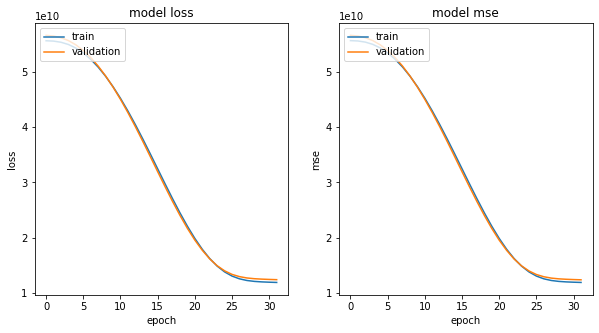

In [136]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'mse']):  
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

#### **Exercise**:   In the next two cells, read in the test.csv file and validate that there are no null values.

In [0]:
#TODO - YOUR CODE HERE
#OBJECTIVE:  Load and pre-process test data

In [137]:
#SOLUTION

test_data = pd.read_csv('test.csv')
test_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-119.20,34.18,22.0,6465.0,1397.0,2694.0,1370.0,2.9832,165600.0,NEAR OCEAN
1,-121.96,37.85,10.0,3209.0,379.0,1199.0,392.0,12.2478,500001.0,INLAND
2,-117.97,33.69,21.0,4112.0,580.0,1886.0,581.0,6.7990,292000.0,<1H OCEAN
3,-118.72,34.28,18.0,2229.0,371.0,1283.0,379.0,5.5955,217700.0,<1H OCEAN
4,-115.57,32.80,33.0,1192.0,213.0,1066.0,211.0,4.5714,68600.0,INLAND


In [0]:
#TODO - YOUR CODE HERE
##OBJECTIVE:  Load and pre-process test data

In [138]:
#SOLUTION
#No null values.
test_data.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

#### **Exercise**:   **RUN** the cells to create the input function for the test data and to initialize the test_predict variable.

In [0]:
def test_input_fn(features, batch_size=256):
    """An input function for prediction."""
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

In [0]:
test_predict = test_input_fn(dict(test_data))

## Prediction:  Linear Regression

To predict with Keras, you simply call [model.predict()](https://keras.io/models/model/#predict) and pass in the housing features you want to predict the median_house_value for. Note:  We are predicting the model locally.

#### **Exercise**:   **RUN** the cell to create the median house value prediction on the test data.


In [0]:
predicted_median_house_value=model.predict(test_predict)

#### **Exercise**:  Write a prediction DataFrame for a linear regression model

In [0]:
#TODO - YOUR CODE HERE.  
#OBJECTIVE:  Create and test a prediction model
#HINT:  Copy the first line from the test.csv you read in earlier.

In [142]:
#SOLUTION
#Prediction model:  Pass in the features from one row of the test data.

#This example shows median house value of $117,800 for INLAND property.

#Copy of first line from my test.csv:  Note, do not include the median house value ($117,800), 
#that is what we are trying to predict.

#-121.86	39.78	12.0	7653.0	1578.0	3628.0	1494.0	3.0905	117800.0	INLAND

model.predict({
    'longitude': tf.convert_to_tensor([-121.86]),
    'latitude': tf.convert_to_tensor([39.78]),
    'housing_median_age': tf.convert_to_tensor([12.0]), 		
    'total_rooms': tf.convert_to_tensor([7653.0]),
    'total_bedrooms': tf.convert_to_tensor([1578.0]),  
    'population': tf.convert_to_tensor([3628.0]),
    'households': tf.convert_to_tensor([1494.0]),	
    'median_income': tf.convert_to_tensor([3.0905]),
    'ocean_proximity': tf.convert_to_tensor(['INLAND'])
    
}, steps=1)

array([[228747.08]], dtype=float32)

In [144]:
##SOLUTION - NEAR OCEAN:  Median_house_value is $249,000.


model.predict({
    'longitude': tf.convert_to_tensor([-122.43]),
    'latitude': tf.convert_to_tensor([37.63]),
    'housing_median_age': tf.convert_to_tensor([34.0]), 		
    'total_rooms': tf.convert_to_tensor([4135.0]),
    'total_bedrooms': tf.convert_to_tensor([687.0]),  
    'population': tf.convert_to_tensor([2154.0]),
    'households': tf.convert_to_tensor([742.0	]),	
    'median_income': tf.convert_to_tensor([4.9732]),
    'ocean_proximity': tf.convert_to_tensor(['NEAR OCEAN'])
    
}, steps=1)

array([[222368.2]], dtype=float32)

#### **Exercise**:  Analysis

The array returns a predicted value.  What does this number mean?  Let's compare this value to the test set.   

Go to the test.csv you read in a few cells up.  Locate the first line and find the median_house_value - which should be 249,000 dollars near the ocean. What value did your model predicted for the median_house_value? Was it a solid model performance? Let's see if we can improve this a bit with feature engineering!  


#### **Exercise**:   Create a cell that indicates which features will be used in the model.

Note:  Be sure to bucketize 'housing_median_age' and ensure that 'ocean_proximity' is one-hot encoded.  And, don't forget your numeric values!


In [0]:
#TODO - YOUR CODE HERE
#OBJECTIVE - Apply feature engineering to improve model performance

In [0]:
#SOLUTION
num_c = ['longitude',  'latitude',
                'housing_median_age', 'total_rooms', 'total_bedrooms', 
                 'households','population', 'median_income']

bucket_c = ['housing_median_age']

#categorical features
cat_i_c = ['ocean_proximity'] #indicator columns


#### **Exercise**:   **RUN** the next two cells to scale the features.



In [0]:
#Scalardef get_scal(feature):

def get_scal(feature):
  def minmax(x):
    mini = train[feature].min()
    maxi = train[feature].max()
    return (x - mini)/(maxi-mini)
  return(minmax)

In [0]:
#All numeric features -scaling

feature_columns = []
for header in num_c:
  scal_input_fn = get_scal(header)
  feature_columns.append(feature_column.numeric_column(header, normalizer_fn=scal_input_fn))


### Categorical Feature
In this dataset, 'ocean_proximity' is represented as a string.  We cannot feed strings directly to a model. Instead, we must first map them to numeric values. The categorical vocabulary columns provide a way to represent strings as a one-hot vector.

#### **Exercise**:   Create a categorical feature using 'ocean_proximity'.



In [0]:
#TODO - YOUR CODE HERE
#OBJECTIVE - Apply feature engineering to improve model performance

In [0]:
#SOLUTION

for feature_name in cat_i_c:
  vocabulary = dataframe[feature_name].unique()
  cat_c = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)
  one_hot = feature_column.indicator_column(cat_c)
  feature_columns.append(one_hot)

### Bucketized Feature

Often, you don't want to feed a number directly into the model, but instead split its value into different categories based on numerical ranges. Consider our raw data that represents a homes' age. Instead of representing the house age as a numeric column, we could split the hoome age into several buckets using a [bucketized column](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column). Notice the one-hot values below describe which age range each row matches.

#### **Exercise**:   Create a Bucketized column using 'housing_median_age'

In [0]:
#TODO - YOUR CODE HERE
#OBJECTIVE - Apply feature engineering to improve model performance

In [0]:
#SOLUTION

Age = feature_column.numeric_column("housing_median_age")

# bucketized cols
age_buckets = feature_column.bucketized_column(Age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)



### Feature Cross

Combining features into a single feature, better known as [feature crosses](https://developers.google.com/machine-learning/glossary/#feature_cross), enables a model to learn separate weights for each combination of features.

#### **Exercise**:   Create a Feature Cross of  'housing_median_age' and 'ocean_proximity'.

In [0]:
#TODO - YOUR CODE HERE
#OBJECTIVE - Apply feature engineering to improve model performance

In [0]:
#SOLUTION

vocabulary = dataframe['ocean_proximity'].unique()
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list('ocean_proximity', vocabulary)

crossed_feature = feature_column.crossed_column([age_buckets, ocean_proximity], hash_bucket_size=1000)
crossed_feature = feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

#### **Exercise**:   **RUN** the cell to determine the number of feature columns you now have.  Compare this number to the previous number of features.

In [44]:
print('Total number of feature coumns: ',len(feature_columns))

Total number of feature coumns:  11


#### **Exercise**:   **RUN** the cell to create, compile, and train the Keras model.





In [0]:
#TODO - YOUR CODE HERE
#OBJECTIVE - Create, compile, and train the Keras model.

In [45]:
#SOLUTION

#Model create
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12,  input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

#Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])  

### Model Fit
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=32)


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Epoch 1/32
409/409 [==============================] - 5s 12ms/step - loss: 55769079617.7213 - mse: 55786254336.0000 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 2/32
409/409 [==============================] - 2s 4ms/step - loss: 55637800700.2941 - mse: 55622926336.0000 - val_loss: 56623064352.3107 - val_mse: 56620802048.0000
Epoch 3/32
409/409 [==============================] - 2s 4ms/step - loss: 55071168819.3545 - mse: 55096991744.0000 - val_loss: 55855798649.7864 - val_mse: 55853756416.0000
Epoch 4/32
409/409 [==============================] - 2s 4ms/step - loss: 54080822698.9599 - mse: 54079606784.0000 - val_lo

#### **Exercise**:   **RUN** the next two cells to show loss and accuracy and to plot the model.


In [46]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

128/128 [==============================] - 1s 6ms/step - loss: 9591460480.0000 - mse: 9590267904.0000
Accuracy 9590268000.0


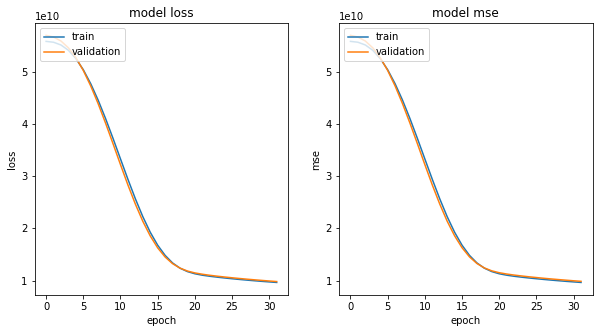

In [47]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'mse']):  
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

#### **Exercise**:  Create a prediction model.  Note:  You may use the same values from the previous prediciton.



In [0]:
#TODO - YOUR CODE HERE.
#OBJECTIVE - Create and test a prediction model 
#HINT - Pass in the features from one row of the test data.

In [48]:
#SOLUTION:  INLAND: Median_house_value is $117,800 

#Copy of first line from my test.csv: 
#-121.86	39.78	12.0	7653.0	1578.0	3628.0	1494.0	3.0905	117800.0	INLAND

model.predict({
    'longitude': tf.convert_to_tensor([-121.86]),
    'latitude': tf.convert_to_tensor([39.78]),
    'housing_median_age': tf.convert_to_tensor([12.0]), 		
    'total_rooms': tf.convert_to_tensor([7653.0]),
    'total_bedrooms': tf.convert_to_tensor([1578.0]),  
    'population': tf.convert_to_tensor([3628.0]),
    'households': tf.convert_to_tensor([1494.0]),	
    'median_income': tf.convert_to_tensor([3.0905]),
    'ocean_proximity': tf.convert_to_tensor(['INLAND'])
    
}, steps=1)

array([[177094.1]], dtype=float32)

In [50]:
#SOLUTION - NEAR OCEAN:  Median_house_value is $249,000.

model.predict({
    'longitude': tf.convert_to_tensor([-122.43]),
    'latitude': tf.convert_to_tensor([37.63]),
    'housing_median_age': tf.convert_to_tensor([34.0]), 		
    'total_rooms': tf.convert_to_tensor([4135.0]),
    'total_bedrooms': tf.convert_to_tensor([687.0]),  
    'population': tf.convert_to_tensor([2154.0]),
    'households': tf.convert_to_tensor([742.0	]),	
    'median_income': tf.convert_to_tensor([ 4.9732]),
    'ocean_proximity': tf.convert_to_tensor(['NEAR OCEAN'])
    
}, steps=1)

array([[237944.67]], dtype=float32)

### Analysis 

The array returns a predicted value.  Compare this value to the test set you ran earlier. Your predicted value may be a bit better.

Now that you have your "feature engineering template" setup, you can experiment by creating additional features.  For exmample, you can create derived features, such as households per population, and see how they impact the model.  You can also experiment with replacing the features you used to create the feature cross.
 